# Ecuación de calor
 
$$
\frac{\mathrm{d}u}{\mathrm{d}t}-D\Delta u=
0.
$$

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import xarray as xr
from ipywidgets import Video
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

## Problema

Se tiene una plancha metálica de un tamaño $2\times 2$ cm.
La misma contiene aislante en sus bordes por lo que la temperatura externa no puede afectar la placa ni viceversa.
El coeficiente de difusión de este material es $D=1.01\times 10^{−5}\frac{\mathrm{m}^2}{\mathrm{s}}$.
La misma tiene un estado inicial de temperatura.
¿Cuál sería el estado de la temperatura pasado un tiempo $T$?

## Tareas

1. Cree una rejilla de $2\times 2$ cm donde $\Delta x=\Delta y=0.01$ cm la cual estará centrada en el origen de coordenadas $\left(0,0\right)$.

In [2]:
dx = 0.01
dy = 0.01

sizex = 2
sizey = 2

centerx = 0
centery = 0

x = np.arange(centerx - sizex / 2, centerx + sizex / 2 + dx, dx)
y = np.arange(centery - sizey / 2, centery + sizey / 2 + dy, dy)

xx, yy = np.meshgrid(x, y)

print(f"Discretización horizontal: dx={dx} dy={dy}")
print(f"Longitud de la rejilla: {sizex}cm x {sizey}cm")
print(f"Tamaño de la rejilla: {xx.shape}")
print(f"Coordenadas del centro: {centerx,centery}")

Discretización horizontal: dx=0.01 dy=0.01
Longitud de la rejilla: 2cm x 2cm
Tamaño de la rejilla: (201, 201)
Coordenadas del centro: (0, 0)


2. Cree una discretización del intervalo de tiempo $t\in\left[0,T\right]$ con un paso temporal $\Delta t=\frac{r\Delta x^2}{D}$ donde $r=0.2$ es el coeficiente de estabilidad CFL.

In [3]:
D = 1.01e-5
PI = np.pi

r = 0.2
dt = (r * dx**2) / D

print(f"Discretización temporal: dt={dt:0.2f}")
print(f"Coeficiente de estabilidad: r={r}")
print(f"Coeficiente de difusion: D={D}")

Discretización temporal: dt=1.98
Coeficiente de estabilidad: r=0.2
Coeficiente de difusion: D=1.01e-05


3. Establezca las condiciones iniciales a partir de la siguiente función:

$$
f_{0}\left(x,y\right)=
1+
\operatorname{sen}\left(2\pi\Delta T\right)
\left(\cos\left(4\pi x\right)+\operatorname{sen}\left(4\pi y\right)\right)
$$

In [4]:
# Definimos las condiciones iniciales
f0 = 1 + np.sin(2 * PI * dt) * (np.cos(4 * PI * xx) + np.sin(4 * PI * yy))

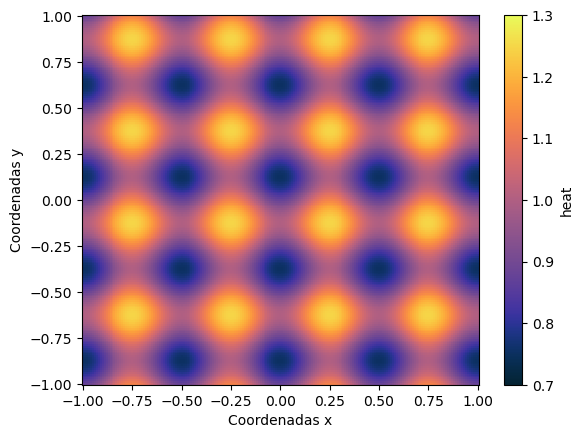

In [5]:
# Usando xarray podemos observar nuestras condiciones iniciales
# de manera sencilla, gracias al manejo de coordenadas con nombre
xf0 = xr.DataArray(f0, coords=[y, x], dims=["y", "x"])
xf0.name = "heat"
xf0.x.attrs["long_name"] = "Coordenadas x"
xf0.y.attrs["long_name"] = "Coordenadas y"
xf0.plot(cmap=cmo.cm.thermal, vmin=0.7, vmax=1.3)

Ahora definimos una funcion que nos permita hacer el plot en 3d

In [6]:
def plot3d(
    data,
    xx,
    yy,
    x,
    y,
    dx,
    dy,
    title="Initial conditions",
    save=False,
    fname="plot",
    title_kwargs={},
):
    fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(8, 8), dpi=300)
    ax.plot_surface(xx, yy, data, cmap=cmo.cm.thermal, vmin=0.7, vmax=1.30)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title, **title_kwargs)
    ax.set_zlim(0.5, 1.5)
    ax.set_xlim(x.min() - 10 * dx, x.max() + 10 * dx)
    ax.set_ylim(y.min() - 10 * dy, y.max() + 10 * dy)

    if save:
        fig.savefig(fname, bbox_inches="tight", dpi=300, transparent=True)

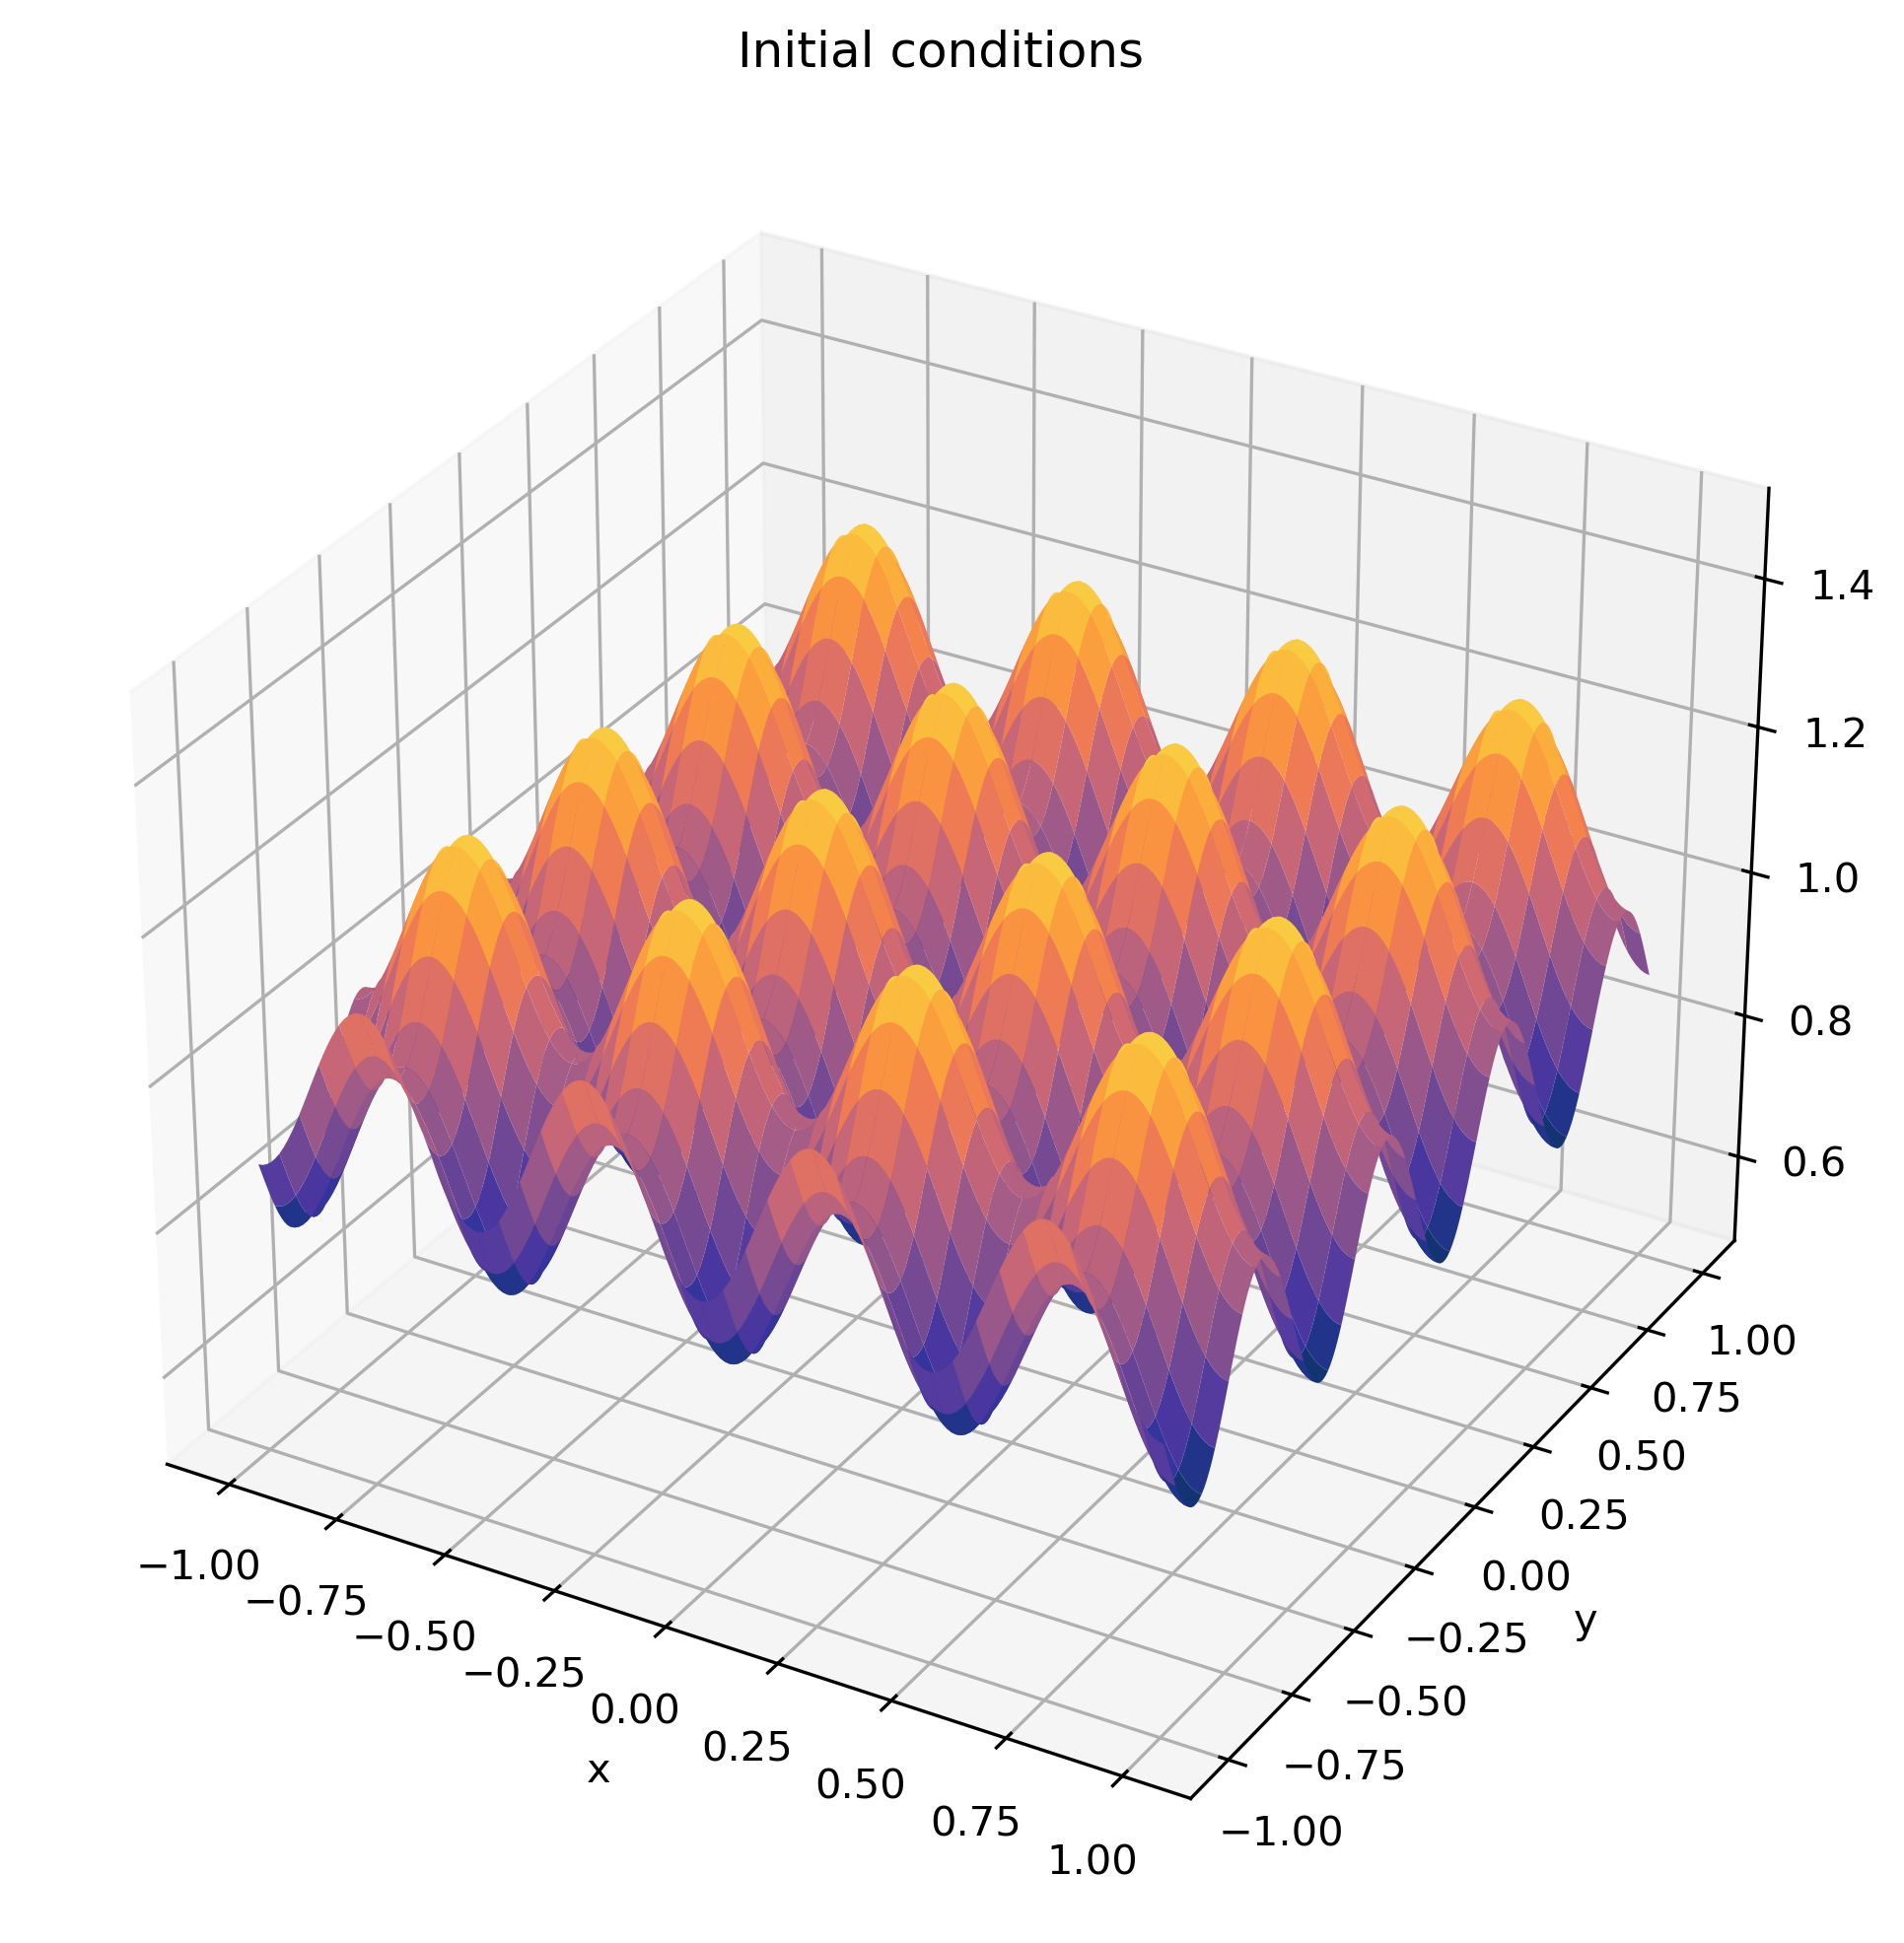

In [7]:
plot3d(xf0, xx, yy, x, y, dx, dy)

4. Cree las matrices A y B correspondientes al método de Crank-Nicolson.

In [8]:
def create_A(r, N):
    d0_L = np.full(N * N, 1.0 + 2.0 * r)
    d1_L = np.tile(np.concatenate([[0.0, -r], np.full(N - 2, -r / 2.0)]), N)
    dm1_L = np.flip(d1_L)

    # Aca debemos de crear dos veces el array con -r
    # esto es debido al alignment que hace scipy desde la base
    # y no desde el comienzo del array
    d_A = np.concatenate(
        [np.full(N, -r), np.full(N, -r), np.full(N * (N - 2), -r / 2.0)]
    )

    return spdiags(
        [np.flip(d_A), dm1_L, d0_L, d1_L, d_A], [-N, -1, 0, 1, N], N * N, N * N
    ).tocsr()


def create_B_hat(r, N):
    d0_Q = np.full(N * N, 1.0 - 2.0 * r)
    d1_Q = np.tile(np.concatenate([[0.0, r], np.full(N - 2, r / 2.0)]), N)
    dm1_Q = np.flip(d1_Q)

    # Similar que en A
    d_B = np.concatenate([np.full(N, r), np.full(N, r), np.full(N * (N - 2), r / 2.0)])

    return spdiags(
        [np.flip(d_B), dm1_Q, d0_Q, d1_Q, d_B], [-N, -1, 0, 1, N], N * N, N * N
    ).tocsr()

Ahora vamos a explorar que nuestras funciones creen las matrices de manera correcta, para ello haremos uso de sympy

In [9]:
A = sp.Matrix(create_A(0.5, 3).todense())
A

Matrix([
[  2.0,  -0.5,     0,  -0.5,    0,     0,     0,     0,     0],
[-0.25,   2.0, -0.25,     0, -0.5,     0,     0,     0,     0],
[    0,  -0.5,   2.0,     0,    0,  -0.5,     0,     0,     0],
[-0.25,     0,     0,   2.0, -0.5,     0, -0.25,     0,     0],
[    0, -0.25,     0, -0.25,  2.0, -0.25,     0, -0.25,     0],
[    0,     0, -0.25,     0, -0.5,   2.0,     0,     0, -0.25],
[    0,     0,     0,  -0.5,    0,     0,   2.0,  -0.5,     0],
[    0,     0,     0,     0, -0.5,     0, -0.25,   2.0, -0.25],
[    0,     0,     0,     0,    0,  -0.5,     0,  -0.5,   2.0]])

In [10]:
B_hat = sp.Matrix(create_B_hat(0.5, 3).todense())
B_hat

Matrix([
[   0,  0.5,    0,  0.5,   0,    0,    0,    0,    0],
[0.25,    0, 0.25,    0, 0.5,    0,    0,    0,    0],
[   0,  0.5,    0,    0,   0,  0.5,    0,    0,    0],
[0.25,    0,    0,    0, 0.5,    0, 0.25,    0,    0],
[   0, 0.25,    0, 0.25,   0, 0.25,    0, 0.25,    0],
[   0,    0, 0.25,    0, 0.5,    0,    0,    0, 0.25],
[   0,    0,    0,  0.5,   0,    0,    0,  0.5,    0],
[   0,    0,    0,    0, 0.5,    0, 0.25,    0, 0.25],
[   0,    0,    0,    0,   0,  0.5,    0,  0.5,    0]])

5. Implemente el código restante para resolver la ecuación de calor. Al tratarse de un método implícito entonces en cada iteración se resuelve el sistema:

$$
Au^{n+1} = Bu^{n}
$$

In [ ]:
# Definimos la cantidad de pasos temporales
T = 100  # 1000

# Cada cuanto imprimiremos el porcentaje de avance
ndebug = T // 10

# Copiamos el array inicial en la variable u
u = f0.copy()

# Creamos los arrays que definen la ecuacion
# a resolver
A = create_A(r, u.shape[0])
B_hat = create_B_hat(r, u.shape[0])

# Creamos un contenedor con xarray
# Este DataArray nos permitira hacer slicing
# de manera mas facil sobre los resultados
xr_u = xr.DataArray(
    np.full((T + 1, u.shape[0], u.shape[1]), np.nan),
    coords=dict(
        tstep=np.arange(T + 1),
        y=y,
        x=x,
        time=("tstep", (np.arange(T + 1) * dt).cumsum()),
    ),
    dims=["tstep", "y", "x"],
    name="heat",
)

# El primer elemento temporal seran nuestras condiciones iniciales
xr_u[0] = u

# Itero la cantidad de pasos temporales a resolver
for k in range(1, T + 1):
    u_flat = u.flatten()
    b = B_hat * u_flat
    u_flat = spsolve(A, b)
    u = u_flat.reshape((u.shape[0], u.shape[1]))

    if k % ndebug == 0:
        print(f"Done iteration {k:.0f}: {k / T * 100:.2f}%")
    xr_u[k] = u

Nuestro `DataArray` tiene la siguiente forma

In [ ]:
xr_u

Vamos a revisar algunos de los resultados intermedios para verificar nuestros resultados

In [ ]:
p3d = xr_u.sel(tstep=np.linspace(0, T, 25), method="nearest").plot.surface(
    col="tstep",
    col_wrap=5,
    cmap=cmo.cm.thermal,
    vmin=0.7,
    vmax=1.3,
    xlim=(-1.1, 1.1),
    ylim=(-1.1, 1.1),
    add_colorbar=False,
)

for ax in p3d.axes.flat:
    ax.set_zlim(0.5, 1.5)
    ax.set_zlabel("")
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.draw()

Los plots muestran como la temperatura va evolucionando con cada paso de tiempo, en donde a partir del paso 750 ya se empieza a notar como toda la rejilla se uniformiza en toda la placa.

6. Después de cada iteración cree una figura en 3 dimensiones correspondiente a la solución n-ésima y sálvela en una carpeta local llamada "resultados" utilizando la función `plt.savefig` contenida en el módulo `Matplotlib.pyplot`. \
    Al final de la simulación la distribución de la temperatura debe ser uniforme en toda la placa metálica

In [ ]:
# Realizamos y guardamos los plots usando la funcion que definimos
# Iteramos sobre el DataArray que contiene nuestros resultados intermedios
for num, step in enumerate(xr_u.thin(tstep=10)):
    plot3d(
        step,
        xx,
        yy,
        x,
        y,
        dx,
        dy,
        title=f"tstep:{step.tstep.data:>6} - time value: {step.time.data:>15.2f}",
        save=True,
        fname=f"step_{num:04}.png",
    )
    plt.close()

In [ ]:
!(cat step_*.png | ffmpeg -f image2pipe -r 25 -pattern_type glob -i - -c:v libx265 video.mp4)